# NDIS Dashboard + Predictive Modeling Notebook

This notebook:
1. Reads **Parquet** data from an S3 path (`s3a://ndis-pipeline-processed-bucket/ndis/transformed_data/parquet/`).
2. Performs a **simple regression** using Spark MLlib.
3. Creates a **basic dashboard** with **matplotlib** (bar charts, etc.) to visualize key metrics.

> **Requirements**:
> - You must have run `spark-submit` (or be in a Spark environment) with `hadoop-aws` and `aws-java-sdk` libraries available.
> - Your AWS credentials must be set so Spark can read from S3.
> - You should already have valid Parquet data in your S3 bucket.


In [26]:
%pip install --quiet findspark

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
from pyspark.sql import SparkSession

import findspark

os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages org.apache.hadoop:hadoop-aws:3.3.4,"
    "com.amazonaws:aws-java-sdk-bundle:1.12.262 pyspark-shell"
)

findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("NDIS_Dashboard_and_Prediction")
    .getOrCreate()
)

spark.conf.set("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.DefaultAWSCredentialsProviderChain")

input_parquet_path = "s3a://ndis-pipeline-processed-bucket/ndis/transformed_data/parquet/"
print(f"Reading Parquet from: {input_parquet_path}")

df = spark.read.parquet(input_parquet_path)

print("Schema:")
df.printSchema()
print("Total Rows =", df.count())

Reading Parquet from: s3a://ndis-pipeline-processed-bucket/ndis/transformed_data/parquet/
Schema:
root
 |-- rprtdt: string (nullable = true)
 |-- statecd: string (nullable = true)
 |-- srvcdstrctnm: string (nullable = true)
 |-- dsbltygrpnm: string (nullable = true)
 |-- agebnd: string (nullable = true)
 |-- suppclass: string (nullable = true)
 |-- avganlsdcmtdsuppbdgt: string (nullable = true)
 |-- actvprtcpnt: string (nullable = true)
 |-- source_dataset: string (nullable = true)
 |-- prvdrcnt: string (nullable = true)
 |-- avganlsdpymt: string (nullable = true)

Total Rows = 236267


## 2. Quick Exploratory Analysis
We can do some SQL queries or direct DataFrame ops to see the distribution of certain columns.


In [ ]:
# Create a temp view to run Spark SQL
df.createOrReplaceTempView("ndis_data")

# Example: distribution of dsbltygrpnm (disability group name)
distribution_df = spark.sql("""
    SELECT dsbltygrpnm, COUNT(*) AS count_rows
    FROM ndis_data
    GROUP BY dsbltygrpnm
    ORDER BY count_rows DESC
    LIMIT 10
""")

distribution_pdf = distribution_df.toPandas()
distribution_pdf

Check missing values

In [29]:
df.createOrReplaceTempView("ndis_data")

missing_values_df = spark.sql("""
    SELECT 
        column_name,
        SUM(CASE WHEN column_value IS NULL THEN 1 ELSE 0 END) AS missing_count
    FROM (
        SELECT 'rprtdt' AS column_name, rprtdt AS column_value FROM ndis_data
        UNION ALL
        SELECT 'statecd' AS column_name, statecd AS column_value FROM ndis_data
        UNION ALL
        SELECT 'srvcdstrctnm' AS column_name, srvcdstrctnm AS column_value FROM ndis_data
        UNION ALL
        SELECT 'dsbltygrpnm' AS column_name, dsbltygrpnm AS column_value FROM ndis_data
        UNION ALL
        SELECT 'agebnd' AS column_name, agebnd AS column_value FROM ndis_data
        UNION ALL
        SELECT 'suppclass' AS column_name, suppclass AS column_value FROM ndis_data
        UNION ALL
        SELECT 'avganlsdcmtdsuppbdgt' AS column_name, avganlsdcmtdsuppbdgt AS column_value FROM ndis_data
        UNION ALL
        SELECT 'actvprtcpnt' AS column_name, actvprtcpnt AS column_value FROM ndis_data
        UNION ALL
        SELECT 'source_dataset' AS column_name, source_dataset AS column_value FROM ndis_data
        UNION ALL
        SELECT 'prvdrcnt' AS column_name, prvdrcnt AS column_value FROM ndis_data
        UNION ALL
        SELECT 'avganlsdpymt' AS column_name, avganlsdpymt AS column_value FROM ndis_data
    ) subquery
    GROUP BY column_name
    ORDER BY missing_count DESC
""")

missing_values_pdf = missing_values_df.toPandas()

from IPython.display import display
display(missing_values_pdf)


,column_name,missing_count
0,avganlsdcmtdsuppbdgt,173191
1,avganlsdpymt,170429
2,actvprtcpnt,134998
3,rprtdt,0
4,statecd,0
5,srvcdstrctnm,0
6,dsbltygrpnm,0
7,agebnd,0
8,suppclass,0
9,source_dataset,0


In [30]:
print("Columns:", df.columns)

Columns: ['rprtdt', 'statecd', 'srvcdstrctnm', 'dsbltygrpnm', 'agebnd', 'suppclass', 'avganlsdcmtdsuppbdgt', 'actvprtcpnt', 'source_dataset', 'prvdrcnt', 'avganlsdpymt']


In [31]:
from pyspark.sql.functions import col, count, when

df.select([
    count(when(col("avganlsdpymt").isNull(), 1)).alias("missing_avganlsdpymt"),
    count(when(col("actvprtcpnt").isNull(), 1)).alias("missing_actvprtcpnt"),
]).show()

+--------------------+-------------------+
|missing_avganlsdpymt|missing_actvprtcpnt|
+--------------------+-------------------+
|              170429|             134998|
+--------------------+-------------------+



## 3. Simple Dashboard Using matplotlib
We'll create a bar chart for the `dsbltygrpnm` distribution. 

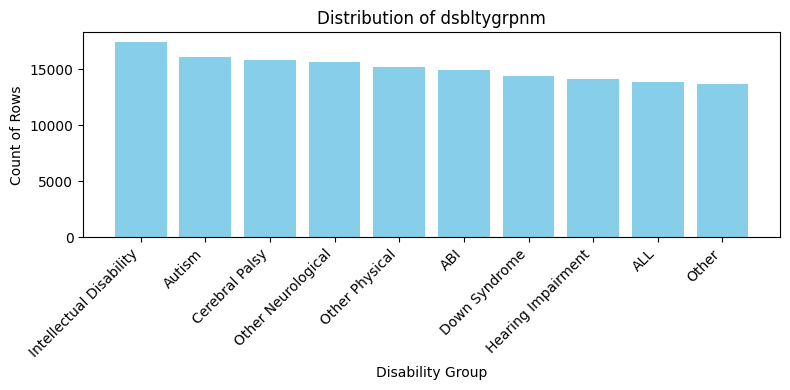

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(distribution_pdf["dsbltygrpnm"], distribution_pdf["count_rows"], color="skyblue")
ax.set_xlabel("Disability Group")
ax.set_ylabel("Count of Rows")
ax.set_title("Distribution of dsbltygrpnm")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4. Simple Predictive Model (Spark MLlib)
We'll do a naive regression. Suppose we want to predict `prvdrcnt` (provider count) using the disability group name `dsbltygrpnm` as categorical feature (very naive).


In [33]:
from pyspark.sql.functions import col

df_model = df.select("dsbltygrpnm", "prvdrcnt")

# Cast 'prvdrcnt' to double and call it 'label' for Spark ML
df_model = df_model.withColumn("label", col("prvdrcnt").cast("double")).drop("prvdrcnt")

# Check row count
print("Total rows in df_model:", df_model.count())

# Example of how the data looks
df_model.show(5, truncate=False)

Total rows in df_model: 236267
+--------------+-----+
|dsbltygrpnm   |label|
+--------------+-----+
|Other         |0.0  |
|Other Physical|0.0  |
|Stroke        |0.0  |
|Other         |0.0  |
|ALL           |0.0  |
+--------------+-----+
only showing top 5 rows



In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression

# 1) StringIndexer: Convert dsbltygrpnm from string → numeric index
indexer = StringIndexer(
    inputCol="dsbltygrpnm",
    outputCol="dsbltygrpnm_index"
)

# 2) OneHotEncoder: Convert index → one-hot vector
encoder = OneHotEncoder(
    inputCols=["dsbltygrpnm_index"],
    outputCols=["dsbltygrpnm_encoded"]
)

# 3) VectorAssembler: Combine encoded feature into "features"
assembler = VectorAssembler(
    inputCols=["dsbltygrpnm_encoded"],
    outputCol="features"
)

# 4) LinearRegression: We'll predict "label" (the prvdrcnt value)
lr = LinearRegression(featuresCol="features", labelCol="label")

# Build the pipeline with all these stages
pipeline = Pipeline(stages=[indexer, encoder, assembler, lr])

# Split data into train/test
train_df, test_df = df_model.randomSplit([0.7, 0.3], seed=123)
print("Training set size:", train_df.count())
print("Test set size:", test_df.count())

# Fit the pipeline
pipeline_model = pipeline.fit(train_df)

print("Pipeline fitted successfully!")

Training set size: 165792
Test set size: 70475


25/02/07 14:13:38 WARN Instrumentation: [08666ae2] regParam is zero, which might cause numerical instability and overfitting.


Pipeline fitted successfully!


## 5. Evaluate on Test Data

In [35]:
# Transform the test data to get predictions
predictions = pipeline_model.transform(test_df)

# Show a few predictions
predictions.select("dsbltygrpnm", "features", "label", "prediction").show(10, truncate=False)

# Evaluate with RegressionEvaluator, or access the LR stage directly
from pyspark.ml.evaluation import RegressionEvaluator

# The LR model is the last stage in the pipeline
lr_model = pipeline_model.stages[-1]  # or pipeline_model.stages[3]
training_summary = lr_model.summary

print("Training RMSE:", training_summary.rootMeanSquaredError)
print("Training R2:", training_summary.r2)

# Evaluate on test set
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)
rmse_test = evaluator.evaluate(predictions)
print("Test RMSE:", rmse_test)

r2_evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="r2"
)
r2_test = r2_evaluator.evaluate(predictions)
print("Test R2:", r2_test)

+-----------+--------------+-----+-----------------+
|dsbltygrpnm|features      |label|prediction       |
+-----------+--------------+-----+-----------------+
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
|ABI        |(20,[5],[1.0])|0.0  |9.966340211086813|
+-----------+--------------+-----+-----------------+
only showing top 10 rows

Training RMSE: 85.40407468885515
Training R2: 0.023541460954755178
Test RMSE: 76.3715310183551
Test R2: 0.02460063541510793


## 6. Next Steps for a Dashboard

- Use **Plotly** or **Bokeh** for interactive Python charts.
- Use **Databricks** built-in visualizations.
- Export aggregated data to a BI tool (Tableau, Power BI, etc.).


In [24]:
# 7. Stop Spark if done
spark.stop()